# Experiments

In [2]:
import pandas as pd
import scipy as sp
import os
import numpy as np
import seaborn as sns
import gdal
import scipy
from scipy.special import digamma
from scipy.special import gamma
from scipy.optimize import root_scalar

In [3]:
# Adapt to load code
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.path.realpath(".")), "code"))
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

# Home-made helpers functions
import mvalab
import vistools
import utils
from settings import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# make /comfy/ notebook 
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (30, 10)
sns.set(color_codes=True)


eps = 10e-8

-----------------

In [4]:
sorted(os.listdir("../data/GRD/Sajnam/"))

['Sajnam_vh_20180517.tif',
 'Sajnam_vh_20180704.tif',
 'Sajnam_vh_20180809.tif',
 'Sajnam_vh_20180914.tif',
 'Sajnam_vv_20180517.tif',
 'Sajnam_vv_20180704.tif',
 'Sajnam_vv_20180809.tif',
 'Sajnam_vv_20180914.tif']

In [5]:
path1_vh = DATA_FOLDER / "GRD" / "Sajnam" / "Sajnam_vh_20180517.tif"
path1_vv = DATA_FOLDER / "GRD" / "Sajnam" / "Sajnam_vv_20180517.tif"

path2_vh = DATA_FOLDER / "GRD" / "Sajnam" / "Sajnam_vh_20180914.tif"
path2_vv = DATA_FOLDER / "GRD" / "Sajnam" / "Sajnam_vv_20180914.tif"

In [6]:
utils.readGTIFFmeta(path1_vh), utils.readGTIFFmeta(path1_vv)

(({'driver': 'GTiff',
   'dtype': 'uint16',
   'nodata': None,
   'width': 718,
   'height': 769,
   'count': 1,
   'crs': CRS.from_epsg(4326),
   'transform': Affine(9.749303621170946e-05, 0.0, 78.55,
          0.0, -9.752925877763236e-05, 24.535)},
  BoundingBox(left=78.55, bottom=24.46, right=78.62, top=24.535)),
 ({'driver': 'GTiff',
   'dtype': 'uint16',
   'nodata': None,
   'width': 718,
   'height': 769,
   'count': 1,
   'crs': CRS.from_epsg(4326),
   'transform': Affine(9.749303621170946e-05, 0.0, 78.55,
          0.0, -9.752925877763236e-05, 24.535)},
  BoundingBox(left=78.55, bottom=24.46, right=78.62, top=24.535)))

In [7]:
utils.readGTIFFmeta(path2_vh), utils.readGTIFFmeta(path2_vv)

(({'driver': 'GTiff',
   'dtype': 'uint16',
   'nodata': None,
   'width': 718,
   'height': 769,
   'count': 1,
   'crs': CRS.from_epsg(4326),
   'transform': Affine(9.749303621170946e-05, 0.0, 78.55,
          0.0, -9.752925877763236e-05, 24.535)},
  BoundingBox(left=78.55, bottom=24.46, right=78.62, top=24.535)),
 ({'driver': 'GTiff',
   'dtype': 'uint16',
   'nodata': None,
   'width': 718,
   'height': 769,
   'count': 1,
   'crs': CRS.from_epsg(4326),
   'transform': Affine(9.749303621170946e-05, 0.0, 78.55,
          0.0, -9.752925877763236e-05, 24.535)},
  BoundingBox(left=78.55, bottom=24.46, right=78.62, top=24.535)))

In [8]:
X1 = np.concatenate([utils.readGTIFF(path1_vv),utils.readGTIFF(path1_vh)], axis=2)
X2 = np.concatenate([utils.readGTIFF(path2_vv),utils.readGTIFF(path2_vh)], axis=2)
X_LR = np.log(X1) - np.log(X2)
X_LR.shape

(769, 718, 2)


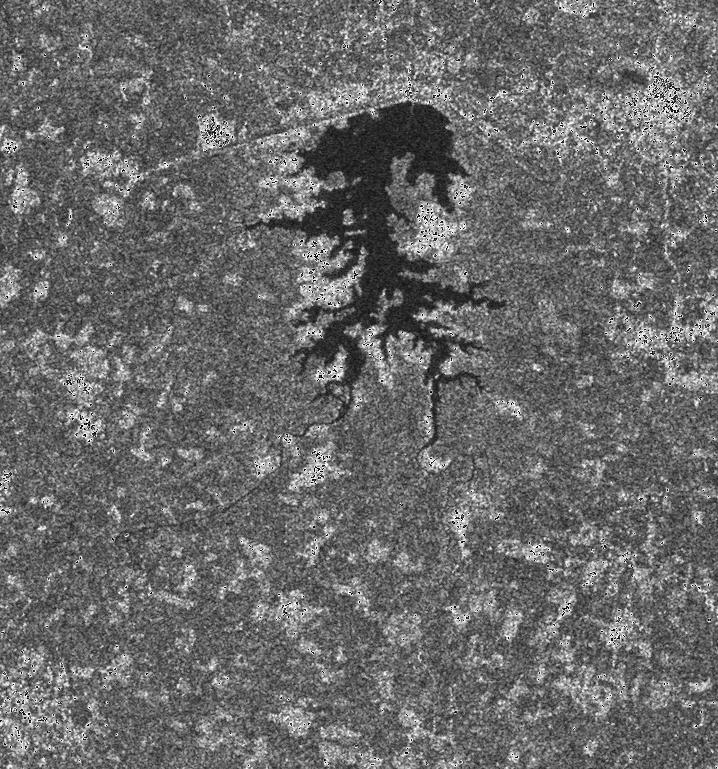
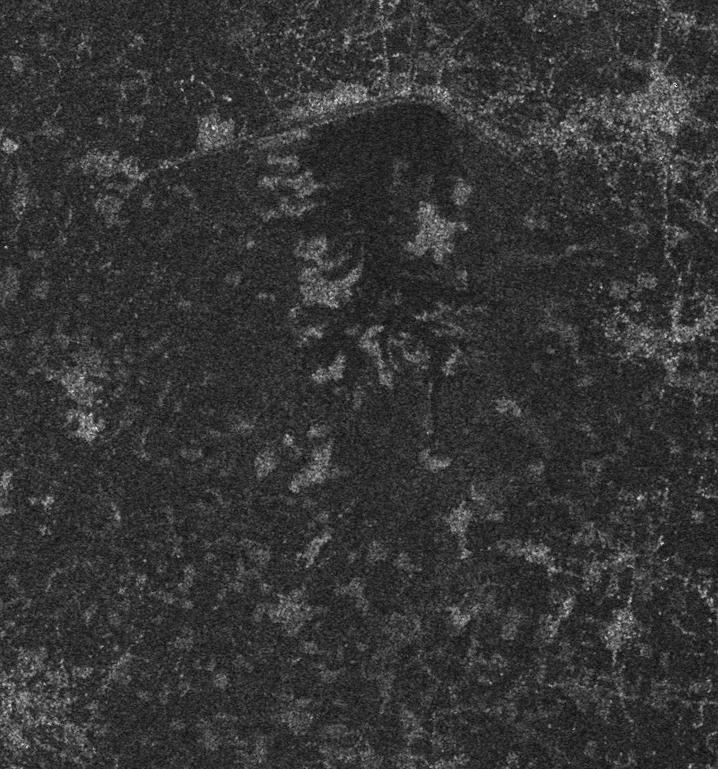
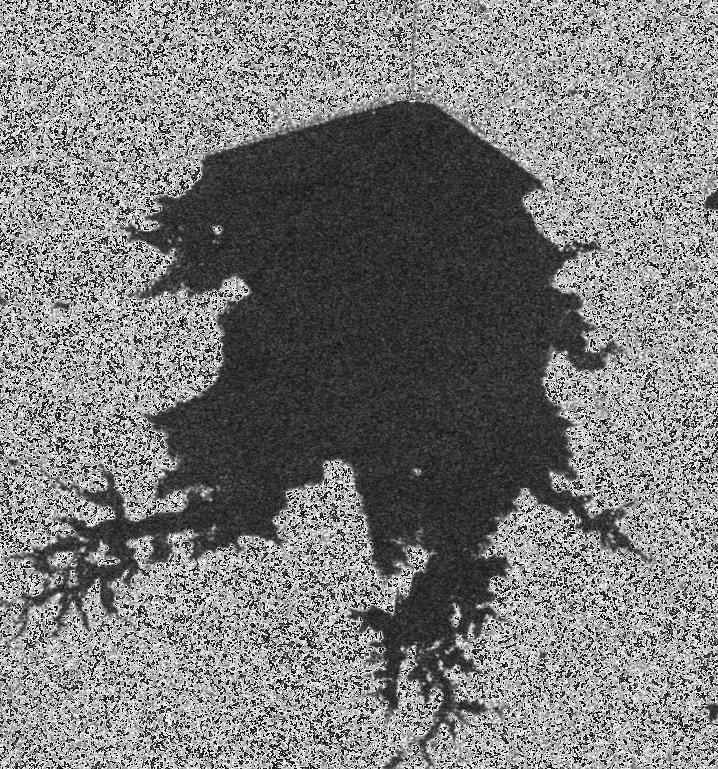
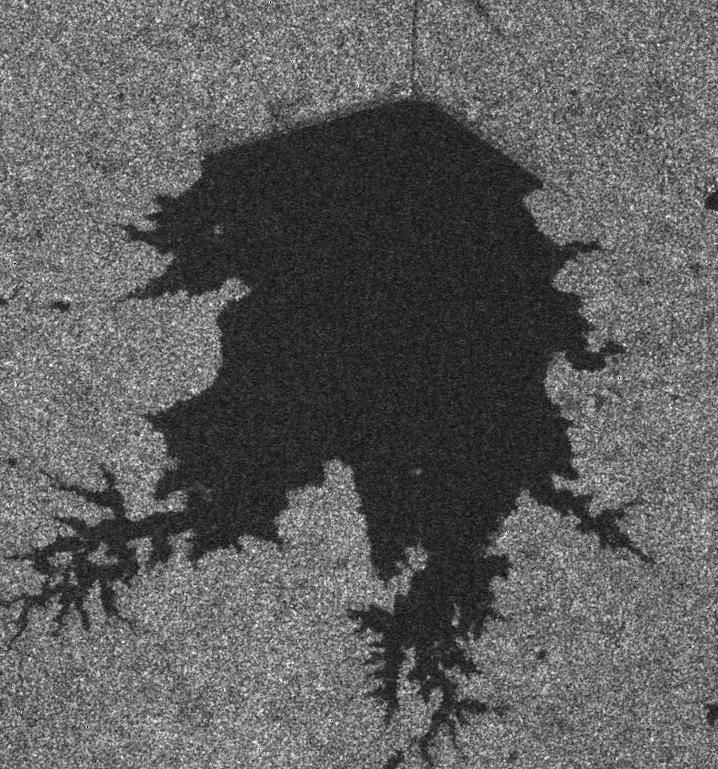
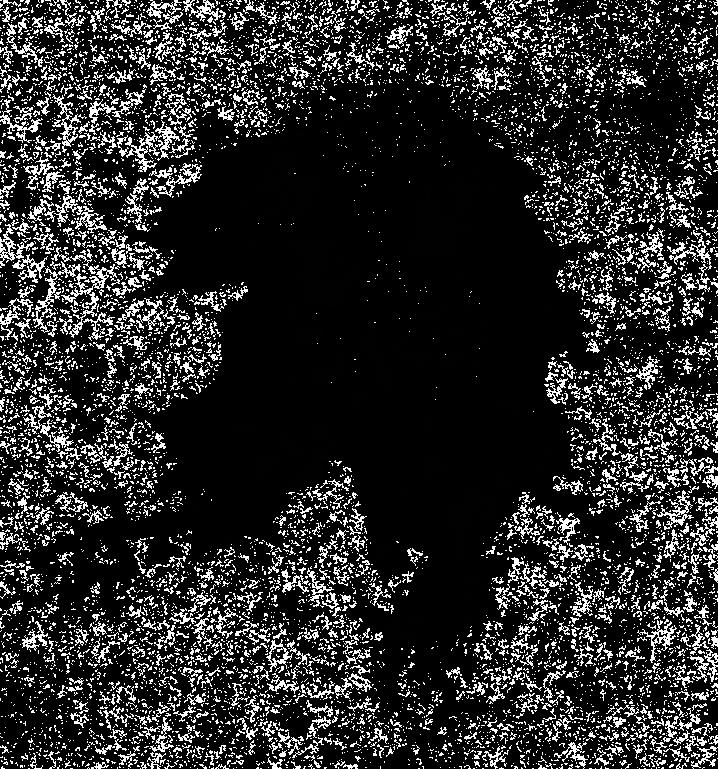
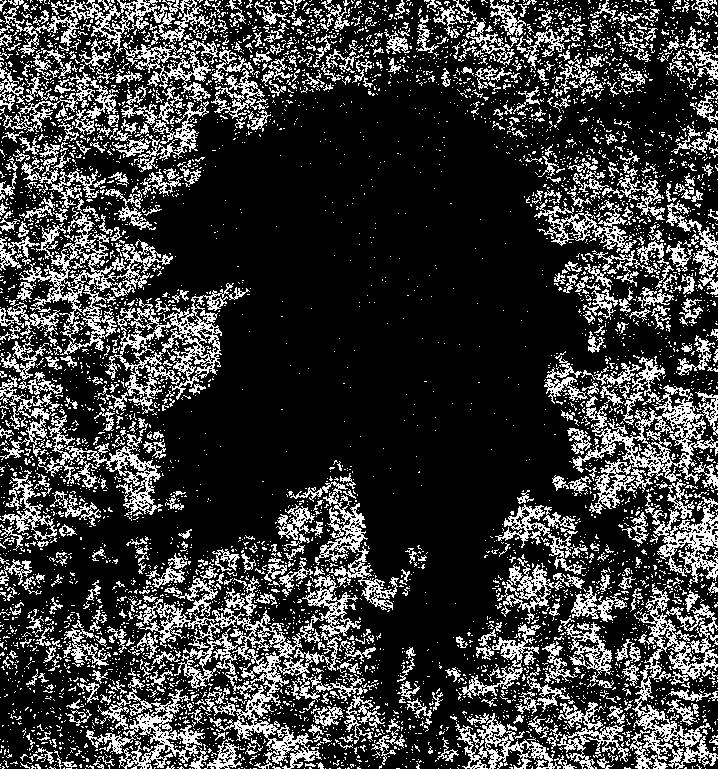

In [9]:
vistools.display_gallery([X1[:,:,0], X1[:,:,1], X2[:,:,0], X2[:,:,1], X_LR[:,:,0], X_LR[:,:,1]])

In [11]:
X_LR_VV = np.ndarray.flatten(X_LR[:,:,0])
X_LR_VH = np.ndarray.flatten(X_LR[:,:,1])

In [12]:
M, N = X_LR[:,:,0].shape

### Cartesian representation of Polarimetric Change Vector

In [13]:
rho = np.sqrt(X_LR_VV ** 2 + X_LR_VH ** 2)

In [14]:
phi = np.arctan2(X_LR_VH, (X_LR_VV + eps))
phi[phi < 0] += 2*np.pi

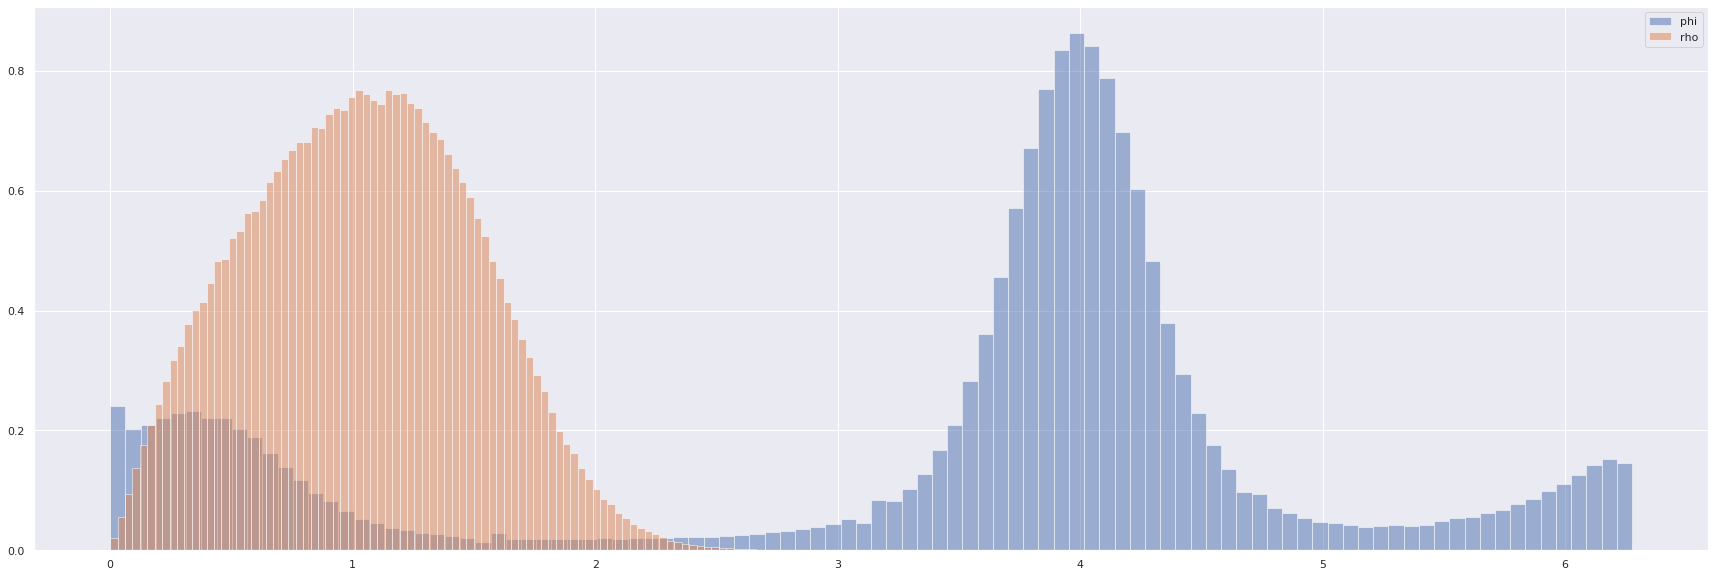

In [15]:
plt.hist(phi, density=True, bins=100, alpha=0.5, label="phi") ;
plt.hist(rho, density=True, bins=100, alpha=0.5, label="rho") ;
plt.legend()

In [16]:
xs = np.cos(phi) * rho
ys = np.sin(phi) * rho

(-3, 3)

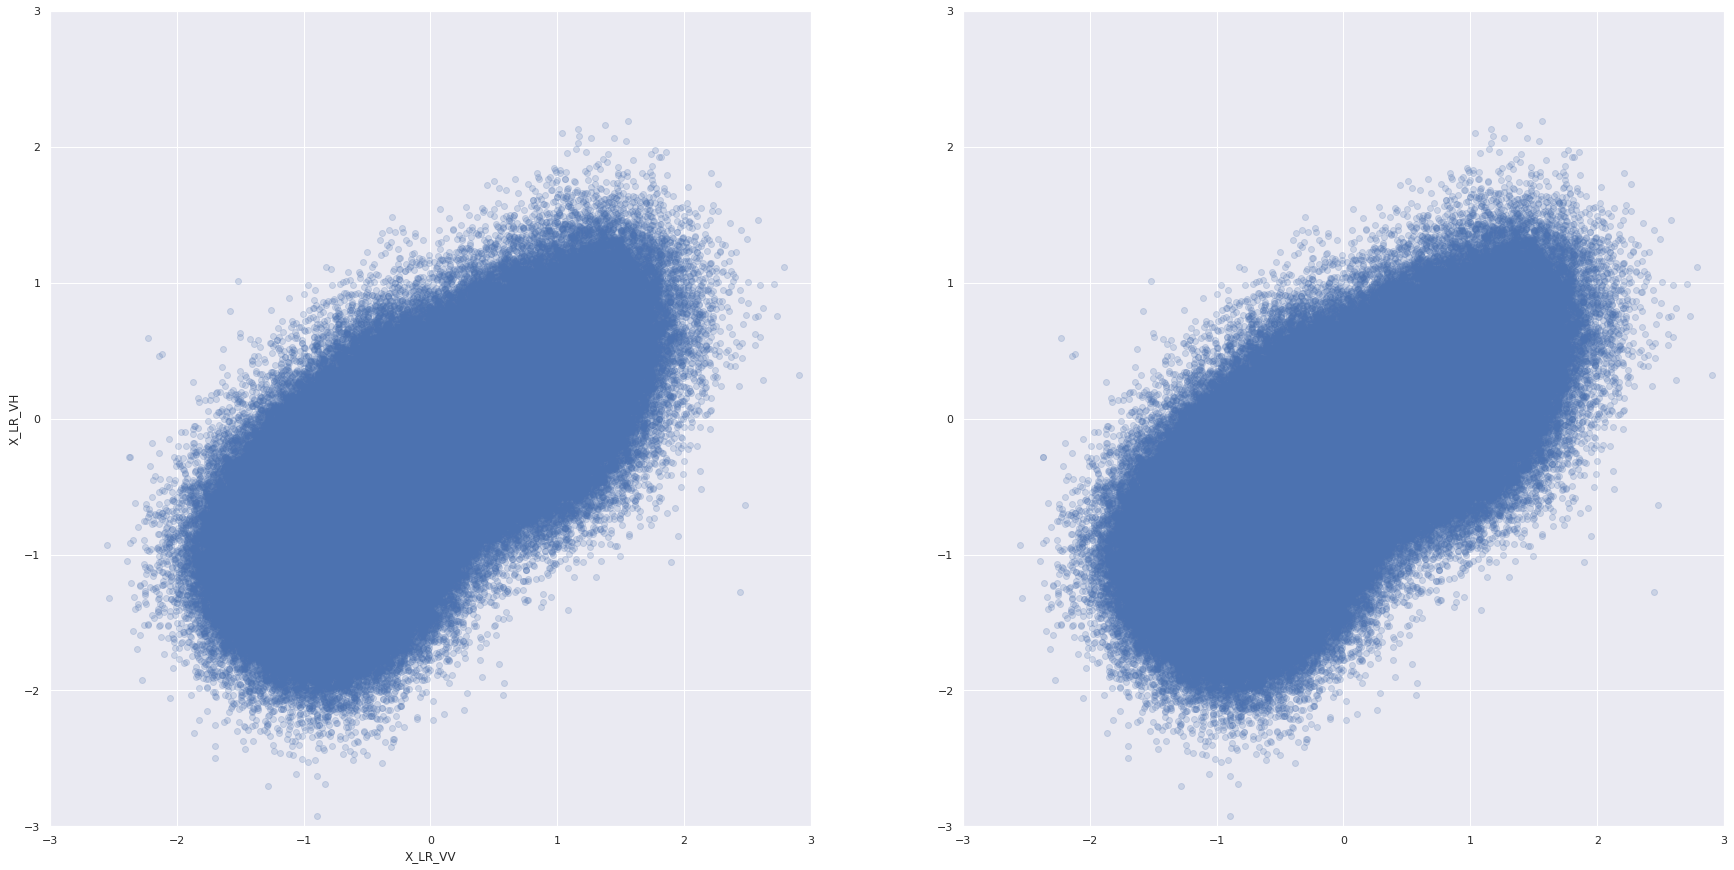

In [17]:
plt.figure(figsize=(30, 15))
plt.subplot(1,2,1)
plt.scatter(X_LR_VV, X_LR_VH, alpha=0.2)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.xlabel("X_LR_VV")
plt.ylabel("X_LR_VH")

plt.subplot(1,2,2)
plt.scatter(xs,ys, alpha=0.2)
plt.xlim((-3,3))
plt.ylim((-3,3))

In [18]:
def nakagami(rho, m, s):
    logg = m * np.log(m + eps) + np.log(2) - np.log(gamma(m)) - m * np.log(s + eps) + (2*m-1) * np.log(rho + eps) - m * rho**2 / s
    return np.exp(logg)

In [42]:
def nakagami_mixture_em(rho, n_class=2, max_iter=100, random_state=42):
    np.random.seed(random_state)

    rho = np.array(rho)

    # N × M here
    n = len(rho)

    P = np.zeros((n_class, max_iter))
    s = np.zeros((n_class, max_iter))
    m = np.zeros((n_class, max_iter))

    # (p(⍵|ρ_i))_i
    p = np.zeros((n, n_class))

    # Initialization: it is hard to tune 
    P[:, 0] = [0.5, 0.5]
    m[:, 0] = [5, 5]
    s[:, 0] = [10, 9]

    # To find m that is implicitly defined using root_scalar
    def f(m, const):
        return digamma(m) - np.log(m) - const

    for t in range(max_iter-1):
        for k in range(n_class):
            p[:, k] = nakagami(rho, m[k, t], s[k, t])

        norm_p = np.tile(p.sum(axis=1), (n_class, 1)).T
        p /= (norm_p + eps)

        P[:, t + 1] = p.sum(axis=0) / n
        for k in range(n_class):
            s[k, t + 1] = (p[:, k] * rho ** 2).sum()
        s[:, t + 1] /= p[:, k].sum()

        for k in range(n_class):
            rho2_on_s = rho ** 2 / s[k, t + 1]
            const = (p[:, k] * (1 - rho2_on_s + np.log(rho2_on_s + eps))).sum() / p[:, k].sum()
            roots = root_scalar(f, args=(const), bracket=[eps,100]).root
            m[k, t + 1] = roots        

    # Sorting on the shape parameter to have the 'nc' class parameters first
    indices = np.argsort(m[:,-1],)
    P = P[indices, :]
    m = m[indices, :]
    s = s[indices, :]
    p = p[:, indices]
    return P, m, s, p

In [24]:
n_class=2
max_iter=100
random_state=42
np.random.seed(random_state)

rho = np.array(rho)

# N × M here
n = len(rho)

P = np.zeros((n_class, max_iter))
s = np.zeros((n_class, max_iter))
m = np.zeros((n_class, max_iter))

# (p(⍵|ρ_i))_i
p = np.zeros((n, n_class))

# Initialization: it is hard to tune 
P[:, 0] = [0.5, 0.5]
m[:, 0] = [5, 5]
s[:, 0] = [10, 9]

# To find m that is implicitly defined using root_scalar
def f(m, const):
    return digamma(m) - np.log(m) - const

In [28]:
rho2_on_s.min(), rho2_on_s.max(), eps

(0.0, 6.918234730869147, 1e-07)

In [ ]:
# Sorting on the shape parameter to have the 'nc' class parameters first
indices = np.argsort(m[:,-1],)
P = P[indices, :]
m = m[indices, :]
s = s[indices, :]
p = p[:, indices]
return P, m, s, p

In [43]:
P, m, s, p = nakagami_mixture_em(rho)

In [46]:
P_star = P[:,-1]
m_star = m[:,-1]
s_star = s[:,-1]

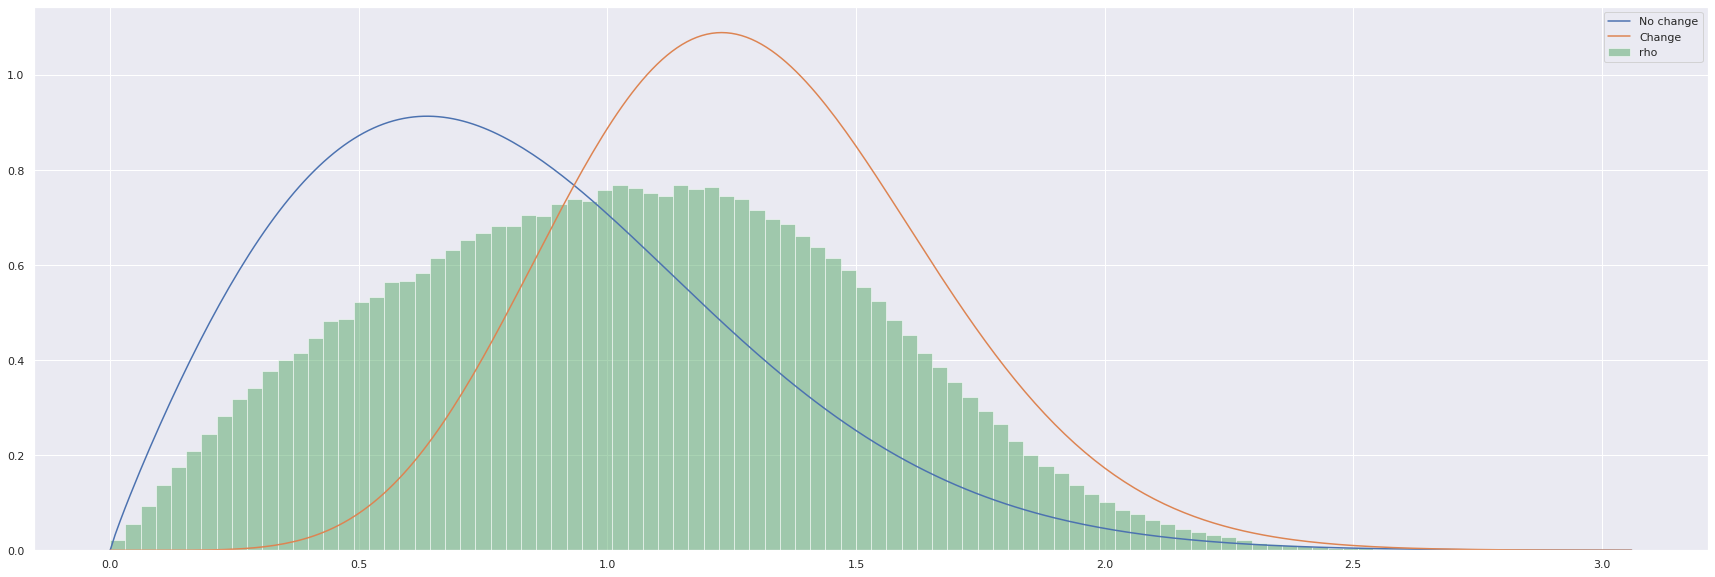

In [47]:
r = np.arange(0,rho.max(), 0.01) + eps

# omega_{nc}
nc = [nakagami(x, m_star[0], s_star[0]) for x in r]

# Omega_c
c = [nakagami(x, m_star[1], s_star[1]) for x in r]

plt.plot(r, nc, label="No change")
plt.plot(r, c, label="Change")
plt.hist(rho, density=True, bins=100, alpha=0.5, label="rho") ;
plt.legend()

In [48]:
unchanged_pixels_index = p[:,0] > 0.5
changed_pixels_index = p[:,0] <= 0.5

(-3, 3)

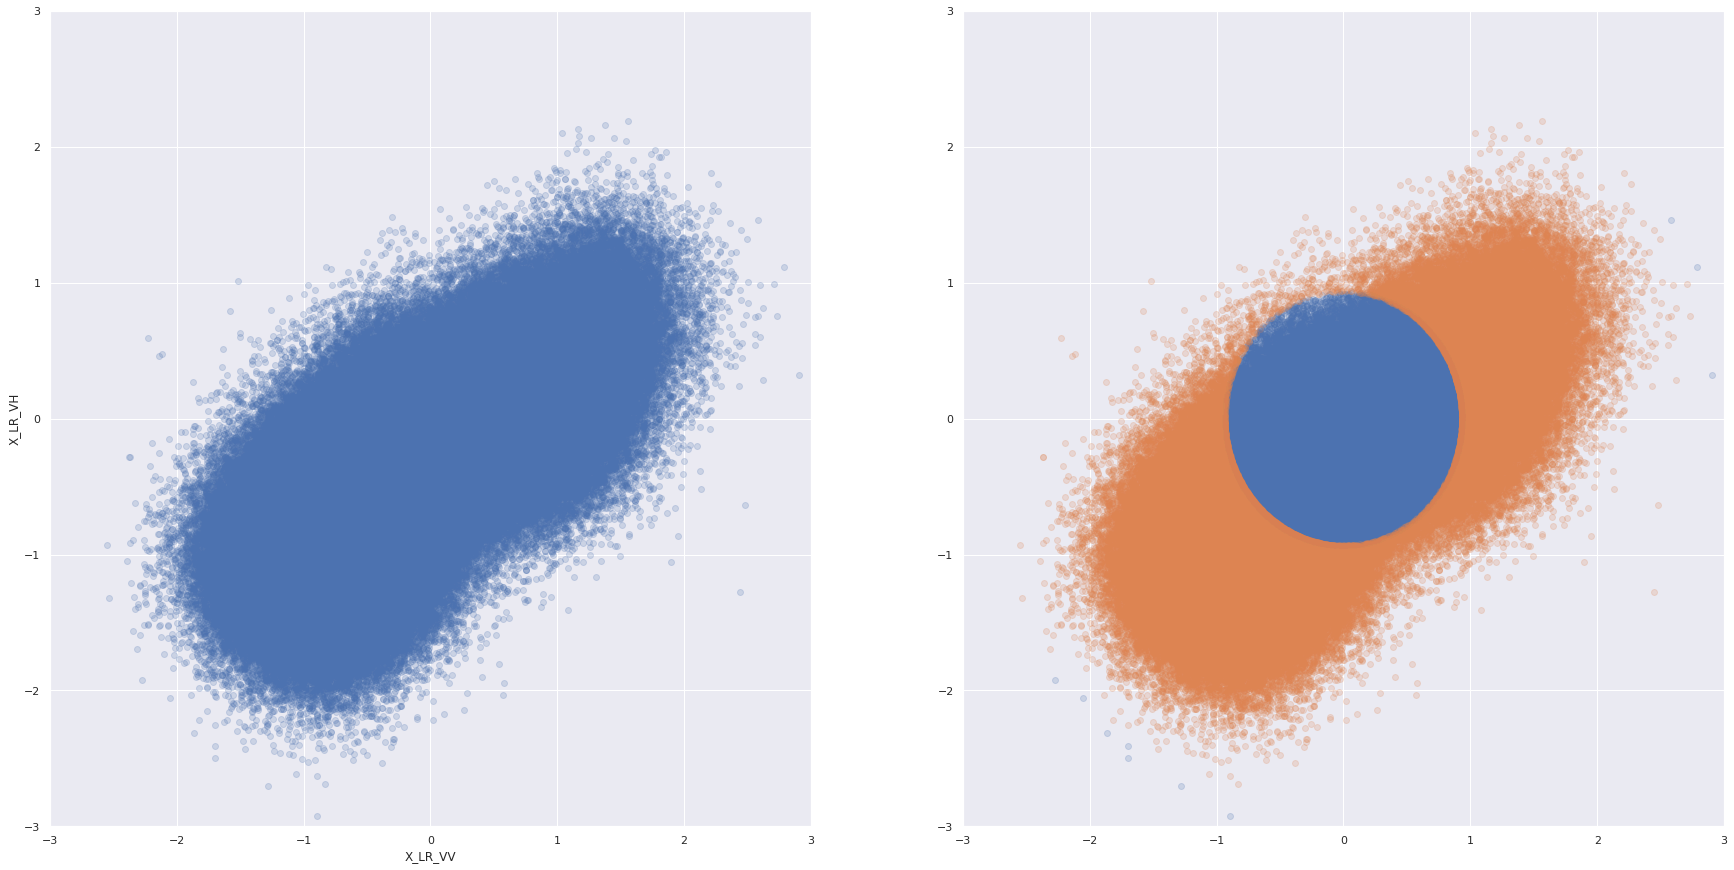

In [49]:
plt.figure(figsize=(30, 15))
plt.subplot(1,2,1)
plt.scatter(X_LR_VV, X_LR_VH, alpha=0.2)
plt.xlim((-3,3))
plt.ylim((-3,3))
plt.xlabel("X_LR_VV")
plt.ylabel("X_LR_VH")

plt.subplot(1,2,2)
plt.scatter(xs[unchanged_pixels_index],ys[unchanged_pixels_index], alpha=0.2)
plt.scatter(xs[changed_pixels_index],ys[changed_pixels_index], alpha=0.2)
plt.xlim((-3,3))
plt.ylim((-3,3))

In [420]:
p[0,:].shape

(2,)

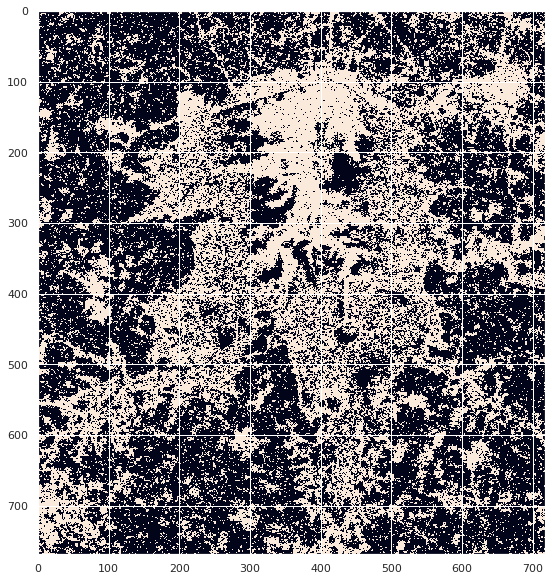

In [62]:
plt.imshow(unchanged_pixels_index.reshape(X1.shape[:2]) * 1)

PosixPath('/home/jsquared/Documents/mva/rsd/projet/data/SLC')

### Inspecting SLC images

In [11]:
from scipy.io.matlab.mio import loadmat

In [ ]:
for im in sorted(os.listdir(SLC_FOLDER)):
    print(im)
    t = loadmat(SLC_FOLDER / im)
    print(t.keys())
    print(f"Header  : {t['__header__']}")
    print(f"Version : {t['__version__']}")
    print(f"Globals : {t['__globals__']}")
    if "liste_dates" in t.keys():
        print(f"Date    : {t['liste_dates']}")
    
    if "moyenne_VH" in t.keys():
        plt.imshow(np.log(1 + t["moyenne_VH"]), cmap="Greys")
        plt.show()
    else:
        plt.imshow(np.log(1 + t["imagesVH"].mean(axis=-1)), cmap="Greys")
        plt.show()

    if "moyenne_VV" in t.keys():
        plt.imshow(np.log(1 + t["moyenne_VV"]), cmap="Greys")
        plt.show()
    else:
        plt.imshow(np.log(1 + t["imagesVV"].mean(axis=-1)), cmap="Greys")
        plt.show()